In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model

plt.style.use("ggplot")

# Estimating Vollenweider parameters

According to Vollenweider (1975), the relationship between lake inflow and outflow concentrations for a non-volatile substance is given by

$$C_{lake} = \frac{C_{in}}{1 + \sigma \tau}$$

where $\tau$ is the water residence time and $\sigma$ is a parameter representing the rate of internal cycling and removal. See [here](https://nivanorge.github.io/teotil2/pages/05_retention.html) for a derivation of this (especially equation 7) and also the paper by [Ahlgren et al. (1988)](https://www.researchgate.net/publication/227035110_Empirical_and_Theoretical_Models_of_Phosphorus_Loading_Retention_and_Concentration_Vs_Lake_Trophic_State), which provides a nice historical overview.

In practice, the parameter $\sigma$ is often not constant and the factors controlling its variation are not well understood. In the original Vollenweider papers focusing on phosphorus, the only reasonable predictor of $\sigma$ was found to be a relationship with $\tau$

$$\sigma = \frac{1}{\tau ^ {0.5}}$$

More generally, many papers choose to model $\sigma$ as $k \tau ^m$. Substituting this into the first equation above gives

$$C_{lake} = \frac{C_{in}}{1 + k \tau ^{(1 + m)}}$$

Note, however, that in principle $\sigma$ and $\frac{1}{\tau}$ have the same dimensions, so using a fractional exponent creates some problems with dimensional consistency (although Vollenweider considered this to be an acceptable empirical "shortcut"). 

Given measured data for $C_{lake}$, $C_{in}$ and $\tau$, we therefore usually want to either:

 1. Use the first equation and estimate $\sigma$ as a constant (referred to as *"Option 1"* below), or
 
 2. Model $\sigma$ as a function of $\tau$ and estimate $k$ and $m$ (referred to as *"Option 2"* below)
 
To reduce the dimensionality of the problem, instead of modelling $C_{out}$ as a function of both $C_{in}$ and $\tau$, we can divide by $C_{in}$ to get the transmission factor for each lake, and then fit this as a function of $\tau$ alone (see also the post [here](https://stackoverflow.com/questions/73825528/fitting-a-curve-to-data-inconsistent-results) for some further relevant details).

`lmfit` provides a general approach for fitting non-linear functions. However, when rearranged to give transmission as a function of $\tau$, these equations can also be fitted using simple linear regression

 * For constant $\sigma$ (*Option 1*)

$$\frac{C_{in}}{C_{out}} = \sigma \tau + 1$$

 * For $\sigma$ as a function of $\tau$ (*Option 2*)

$$log \left( \frac{L_{in}}{L_{out}} - 1 \right) = log(k) + (1 + m) log(\tau)$$

I will use `lmfit` here for simplicity, but `statsmodels` might actually provide slightly richer output.

## 1. Define models

In [36]:
def transmission_sigma_constant(tau, sigma=1):
    return 1 / (1 + (sigma * tau))


def transmission_sigma_as_func_of_tau(tau, k=1, m=1):
    return 1 / (1 + (k * (tau ** (1 + m))))

## 2. Modelling phosphorus

### 2.1. TOTP

The literature provides a fairly good basis for estimating P retention using Vollenweider, because that is what much of the original work focused on. A review paper by [Brett and Benjamin (2008)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2427.2007.01862.x) explored many different approaches, including the two outlined above.

 * For option 1, they found the best-fitting value was $\sigma = 0.45 \pm 0.04$
 
 * For option 2, they found $k = 1.12 \pm 0.08$ and $m = -0.53 \pm 0.03$
 
(**Note:** There is a confusing typo in Table 5 of their paper: in the equation for `Hypothesis 4`, $x_4$ should actually be $(1 + x_4)$).

Of all the methods tested, **option 2 gave the best results**, explaining 84% of the overall variance. Also, the uncertainty estimates on the parameters given in the paper are for 1 standard error, so the 95% CI (roughly 2 standard errors) includes the original Vollenweider approach where $k = 1$ and $m = -0.5$. This is the same as the method used in the original TEOTIL.

In summary, there is a good literature basis for estimating **transmission** of TOTP as

$$T_{TOTP} = \frac{1}{1 + \tau ^{0.5}}$$

which implies **retention** of TOTP is given by

$$R_{TOTP} = \frac{1}{1 + \rho ^{0.5}}$$

where

$$\rho = \frac{1}{\tau}$$

Note that **this is identical to the way TOTP is handled in the original TEOTIL model**, so we don't need to change this.

### 2.2. TDP and TPP

Literature concerning retention of TDP and TPP is a bit sparse. TPP is typically bound to particles and therefore settles and is removed from the lake quickly compared to TDP. Some studies suggest retention of TDP is roughly 60% of retention of TOTP, and this is broadly confirmed by data for Lake Vansjø.

One option for TEOTIL3 is therefore to estimate retention of TDP as

$$R_{TDP} = \frac{0.6}{1 + \rho ^{0.5}}$$

which implies transmission of TDP is

$$T_{TDP} = 0.4 + \frac{0.6}{1 + \tau ^{0.5}}$$

We can then estimate TPP for each model step as the difference between TOTP and TDP. Alternatively we could fit the parameters of Vollenweider such that $R_{TDP} = 0.6R_{TOTP}$ for lakes with $\tau$ roughly equal to Vansjø. If we try this, it would be good to have some more data to further constrain the curve (maybe Mjøsa?).

**Maybe Rolf can suggest alternative approaches and/or datasets?**

## 3. Modelling nitrogen

The literature for N is not as good as that for P. The old TEOTIL model used $R_{TOTN} = 0.2 R_{TOTP}$ based on the work of [Holtan (1991)](https://niva.brage.unit.no/niva-xmlui/handle/11250/206295?locale-attribute=en). However, this study only considers a small number of lakes in South-eastern Norway and the relationship doesn't seem very robust even for these. This approach also implies that retention of TOTN can never be higher than 0.2, which seems low. **Is this realistic?** Hopefully we can improve on this by adding some more data. 

The best thing we've found so far in the recent literature is the dataset from [Steingruber (2020)](https://www.sciencedirect.com/science/article/pii/S0304380019303618), which Leah has extracted and saved to the JupyterHub. Column names in the dataset are as follows:

 * N° denotes the lake number
 * z is the mean depth (m)
 * τ the residence time (yr)
 * RTN the relative retention of TN (proportion of incoming TN)
 * RDIN the relative retention of DIN (proportion of incoming DIN)
 * LTN the areal TN load to the lake (g m-2 yr-1)
 * LDIN the areal DIN load to the lake (g m-2 yr-1)
 * CTP the in-lake concentration of TP (ug/l I think; paper gets this mixed up)
 * TN/TP the weight ratio between in-lake concentrations of TN and TP
 
### 3.1. Load Steingruber dataset

In [37]:
# Drop all lakes apart from those in Norway, Sweden, Finland and Canada?
drop_lakes = True

# Truncate data to just the range of residence times present in the teotil data?
use_teotil_taus = False

In [38]:
data_fpath = r"../../data/steingruber_2020_lake_N_budgets_updated.csv"
countries_to_keep = ["Norway", "Finland", "Sweden", "Canada"]
df_raw = pd.read_csv(data_fpath, index_col=0)

if drop_lakes:
    df = df_raw.query("Location in @countries_to_keep")
else:
    df = df_raw

if use_teotil_taus:
    res_time_fpath = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/lake_residence_times_10m_dem.csv"
    res_time_df = pd.read_csv(res_time_fpath)
    tau_lower = res_time_df["res_time_yr"].quantile(0.05)
    tau_upper = res_time_df["res_time_yr"].quantile(0.95)
    df = df.loc[df["tau"] > tau_lower, :]
    df = df.loc[df["tau"] < tau_upper, :]

# The same lake is often present multiple times for different periods, perhaps
# with different tau, but often not. Average so we have just one value per lake
df = df.groupby("Name").mean()

# Add rho, the water renewal rate (1/yr)
df["rho"] = 1 / df["tau"]

# Add L_out, calculated using reported retention and areal input load
df["LTN_out"] = df["LTN"] * (1 - df["RTN"])
df["LDIN_out"] = df["LDIN"] * (1 - df["RDIN"])

# Add estimates for DON (assume that TON = DON)
df['LDON'] = df['LTN'] - df['LDIN']
# Set any negative values to 0
df.loc[df['LDON'] <= 0, 'LDON'] = 0.01
df['LDON_out'] = df['LTN_out'] - df['LDIN_out']
df.loc[df['LDON_out'] <= 0, 'LDON_out'] = 0.01
# Calculate DON retention
df['RDON'] = 1 - df['LDON_out'] / df['LDON']

df.describe()

,z,tau,RTN,RDIN,LTN,LDIN,LDIN/LTN,CTP,TN/TP,rho,LDON,LTN_out,LDIN_out,LDON_out,RDON
count,100.000000,100.000000,87.000000,29.000000,84.000000,25.000000,16.000000,97.000000,82.000000,100.000000,16.000000,84.000000,25.000000,16.000000,16.000000
mean,8.826000,2.006150,0.364425,0.505862,51.708333,6.720000,0.566250,68.483505,37.128049,8.780675,4.813125,43.195387,5.249200,4.496250,-1.859496
std,15.155648,6.169728,0.231758,0.319861,144.090087,10.628264,0.180624,143.594635,33.061466,26.493471,6.451570,135.215351,9.488761,6.212122,8.040654
min,0.800000,0.005000,-0.110000,-0.220000,2.000000,1.000000,0.090000,0.200000,3.000000,0.016667,0.010000,0.450000,0.020000,0.330000,-32.000000
25%,3.275000,0.200000,0.190000,0.240000,4.750000,1.000000,0.465000,8.000000,14.000000,0.555556,1.000000,1.920000,0.270000,0.772500,0.038542
50%,5.250000,0.650000,0.390000,0.570000,18.000000,2.000000,0.580000,20.000000,28.000000,1.547619,1.000000,9.965000,0.760000,1.135000,0.127083
75%,8.925000,1.800000,0.510000,0.730000,34.000000,4.000000,0.712500,60.000000,45.750000,5.000000,6.750000,26.040000,3.660000,5.835000,0.277500
max,138.000000,60.000000,0.910000,0.980000,1026.000000,43.000000,0.790000,1160.000000,162.000000,200.000000,24.000000,995.220000,35.260000,22.260000,0.590000


**Note:** There is a very different distribution of residence times between the Steingruber dataset and the Norwegian lakes in TEOTIL:

 * **IQR TEOTIL lakes:** 0.003 - 0.045
 * **IQR Steingruber data:** 0.1 - 0.3. And min value is 0.005 i.e. higher than the 25th percentile of TEOTIL lakes.

**It Would be good to add some low tau lakes to this dataset. Maybe Jens Fölster at SLU can point us towards some data from Sweden?**

### 3.2. TOTN

Text(0.5, 0, 'tau [years]')

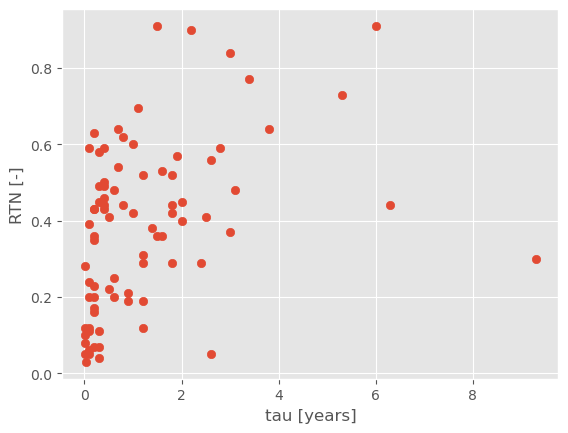

In [39]:
# Get data for TOTN
totn_df = df[["RTN", "tau"]].dropna(how="any")

# Drop negative retention values
totn_df = totn_df.query("RTN > 0")

# Remove one extreme outlier with tau ~60 years
totn_df = totn_df.query("tau < 50")

totn_df["TTN"] = 1 - totn_df["RTN"]

# Sort for plotting
totn_df.sort_values("tau", inplace=True)

# Plot
plt.scatter(totn_df["tau"], totn_df["RTN"], marker="o")
plt.ylabel("RTN [-]")
plt.xlabel("tau [years]")
# plt.xscale("log");

Unfortunately, looking at the raw data, there is no obvious Vollenweider-style relationship for TOTN. In fact, the scatter is so large that it is hard to see any meaningful relationship at all. 

In [40]:
# Try fitting the "option 1" model
model = Model(transmission_sigma_constant, independent_vars=["tau"])
fit1 = model.fit(totn_df["TTN"], tau=totn_df["tau"])
print(fit1.fit_report())
r2 = 1 - fit1.residual.var() / np.var(totn_df["TTN"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 82
    # variables        = 1
    chi-square         = 4.27339089
    reduced chi-square = 0.05275791
    Akaike info crit   = -240.253552
    Bayesian info crit = -237.846833
[[Variables]]
    sigma:  0.71056624 +/- 0.09713105 (13.67%) (init = 1)
R2: -0.06


In [41]:
# Try fitting the "option 2" model
model = Model(transmission_sigma_as_func_of_tau, independent_vars=["tau"])
fit2 = model.fit(totn_df["TTN"], tau=totn_df["tau"])
print(fit2.fit_report())
print(fit2.ci_report())
r2 = 1 - fit2.residual.var() / np.var(totn_df["TTN"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 2
    chi-square         = 2.78730079
    reduced chi-square = 0.03484126
    Akaike info crit   = -273.294937
    Bayesian info crit = -268.481499
[[Variables]]
    k:  0.74567157 +/- 0.06938204 (9.30%) (init = 1)
    m: -0.63488541 +/- 0.07369145 (11.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m) =  0.179
      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k:  -0.19030  -0.13003  -0.06710   0.74567  +0.07317  +0.15494  +0.24892
 m:  -0.20625  -0.13908  -0.07097  -0.63489  +0.07589  +0.15930  +0.25360
R2: 0.29


Both models are highly significant but the second, "option 2", has a substantially lower AIC and a better R2 (although it's still only around 30%).

(<Figure size 640x640 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

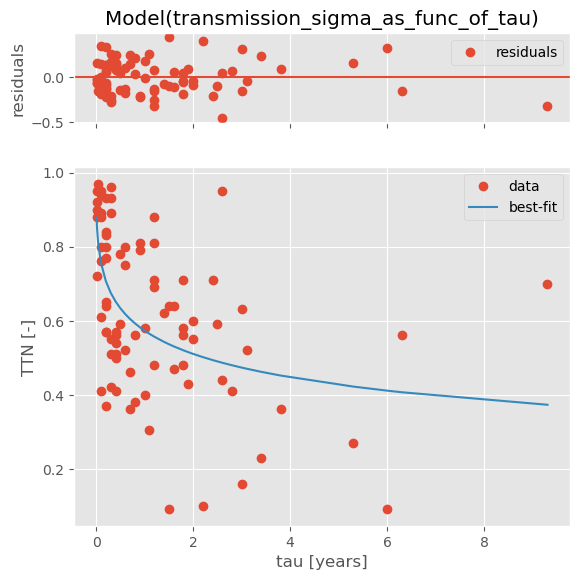

In [42]:
# Plot fit
fit2.plot(xlabel="tau [years]", ylabel="TTN [-]")

This model seems statistically valid and the fit is reasonable, but the results are not robust due to the amount of noise in the dataset. The best parameter estimates are $k = 0.75 \pm 0.07$ and $m = -0.63 \pm 0.07$. Note that the 95% CI for $m$ (roughly two standard errors) just about includes $m = -0.5$, so the main difference between TOTN and TOTP based on these data is that $k = 0.75$ for TOTN, versus $k = 1$ for TOTP.

**Note that these parameters imply much high retention of TOTN than in the original model!**

### 3.3. DIN

Text(0.5, 0, 'tau [years]')

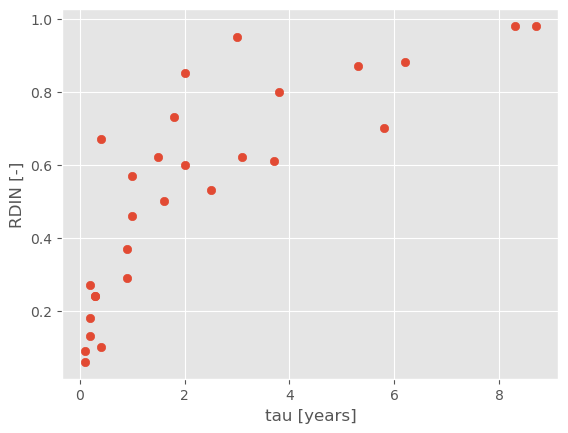

In [43]:
# Get data for DIN
din_df = df[["RDIN", "tau"]].dropna(how="any")

# Drop negative retention values
din_df = din_df.query("RDIN > 0")

# Remove one extreme outlier with tau ~60 years
din_df = din_df.query("tau < 50")

din_df["TDIN"] = 1 - din_df["RDIN"]

# Sort for plotting
din_df.sort_values("tau", inplace=True)

# Plot
plt.scatter(din_df["tau"], din_df["RDIN"], marker="o")
plt.ylabel("RDIN [-]")
plt.xlabel("tau [years]")
# plt.xscale("log");

Compared to the plot for TOTN, the raw data for DIN seem very nice. Fitting a Vollenweider model to these data looks promising.

In [44]:
# Try fitting the "option 1" model
model = Model(transmission_sigma_constant, independent_vars=["tau"])
fit1 = model.fit(din_df["TDIN"], tau=din_df["tau"])
print(fit1.fit_report())
r2 = 1 - fit1.residual.var() / np.var(din_df["TDIN"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 28
    # variables        = 1
    chi-square         = 0.46732178
    reduced chi-square = 0.01730821
    Akaike info crit   = -112.602368
    Bayesian info crit = -111.270164
[[Variables]]
    sigma:  0.95917223 +/- 0.12809944 (13.36%) (init = 1)
R2: 0.80


In [45]:
# Try fitting the "option 2" model
model = Model(transmission_sigma_as_func_of_tau, independent_vars=["tau"])
fit2 = model.fit(din_df["TDIN"], tau=din_df["tau"])
print(fit2.fit_report())
print(fit2.ci_report())
r2 = 1 - fit2.residual.var() / np.var(din_df["TDIN"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 28
    # variables        = 2
    chi-square         = 0.46261526
    reduced chi-square = 0.01779289
    Akaike info crit   = -110.885793
    Bayesian info crit = -108.221384
[[Variables]]
    k:  0.97494917 +/- 0.13097006 (13.43%) (init = 1)
    m: -0.06953908 +/- 0.13285860 (191.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m) = -0.193
      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k:  -0.37931  -0.25086  -0.12759   0.97495  +0.14272  +0.31660  +0.55101
 m:  -0.36587  -0.24474  -0.12556  -0.06954  +0.14283  +0.32066  +0.56917
R2: 0.80


These two models give very similar results, but in this case "option 1" (the simpler model) has a slightly lower AIC. This is because in the second model the parameter $m$ is not significantly different from zero, so the two model essentially reduce to the same thing i.e. the best model here is "pure" Vollenweider with a first order removal term. **This is a really nice result and it's something we can definitely use in the new TEOTIL!**

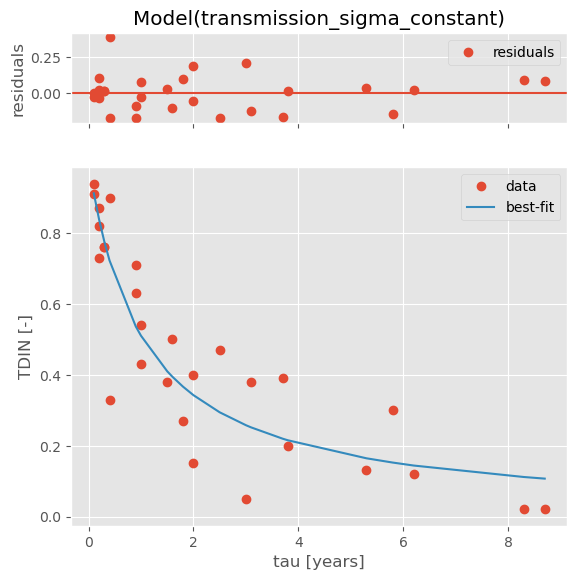

In [46]:
# Plot fit
fit1.plot(xlabel="tau [years]", ylabel="TDIN [-]");

For DIN, the best fit is achieved using "option 1" with $\sigma = 1$.

### 3.4. TON

The fit for DIN is so good that, assuming we are also willing to use results for TOTN from Steingruber, we can simply estimate TON as TOTN minus DIN. However, let's also have a go at fitting RDON using the Steingruber data (and assuming that TON = DON).

Text(0.5, 0, 'tau [years]')

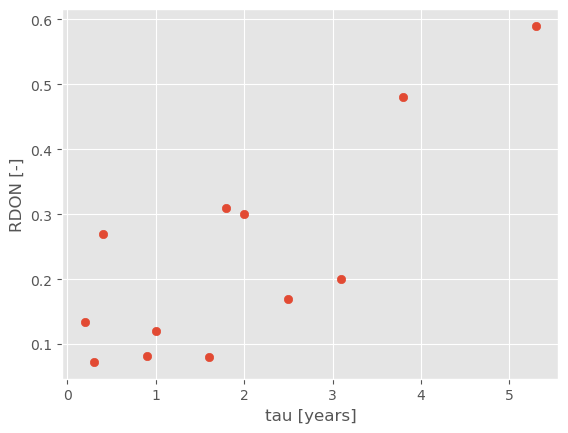

In [47]:
# Get data for DON
don_df = df[["RDON", "tau"]].dropna(how="any")

# Drop negative retention values
don_df = don_df.query("RDON > 0")

# Remove one extreme outlier with tau ~60 years
don_df = don_df.query("tau < 50")

don_df["TDON"] = 1 - don_df["RDON"]

# Sort for plotting
don_df.sort_values("tau", inplace=True)

# Plot
plt.scatter(don_df["tau"], don_df["RDON"], marker="o")
plt.ylabel("RDON [-]")
plt.xlabel("tau [years]")
# plt.xscale("log");

As expected from the TN data, the TON data are very scattered. When you add in data from all lakes (rather than truncating to just Fennoscandia and Canada) then the positive relationship between RDON and tau is a tiny bit more convincing, but not much.

In [48]:
# Try fitting the "option 1" model
model = Model(transmission_sigma_constant, independent_vars=["tau"])
fit1 = model.fit(don_df["TDON"], tau=don_df["tau"])
print(fit1.fit_report())
r2 = 1 - fit1.residual.var() / np.var(don_df["TDON"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 12
    # variables        = 1
    chi-square         = 0.14101717
    reduced chi-square = 0.01281974
    Akaike info crit   = -51.3253629
    Bayesian info crit = -50.8404562
[[Variables]]
    sigma:  0.16887306 +/- 0.03260570 (19.31%) (init = 1)
R2: 0.54


In [49]:
# Try fitting the "option 2" model
model = Model(transmission_sigma_as_func_of_tau, independent_vars=["tau"])
fit2 = model.fit(don_df["TDON"], tau=don_df["tau"])
print(fit2.fit_report())
print(fit2.ci_report())
r2 = 1 - fit2.residual.var() / np.var(don_df["TDON"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 12
    # variables        = 2
    chi-square         = 0.14084467
    reduced chi-square = 0.01408447
    Akaike info crit   = -49.3400517
    Bayesian info crit = -48.3702384
[[Variables]]
    k:  0.15932346 +/- 0.06526094 (40.96%) (init = 1)
    m:  0.05756884 +/- 0.36870380 (640.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m) = -0.867


/opt/conda/lib/python3.10/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(m=2.3718362909148567) = 0.9797190644781504 < max(sigmas).
  warn(errmsg)


      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k:  -0.15898  -0.14160  -0.08693   0.15932  +0.09565  +0.19899  +0.34133
 m:  -1.19037  -0.80648  -0.45207   0.05757  +0.67973  +1.76288      +inf
R2: 0.54


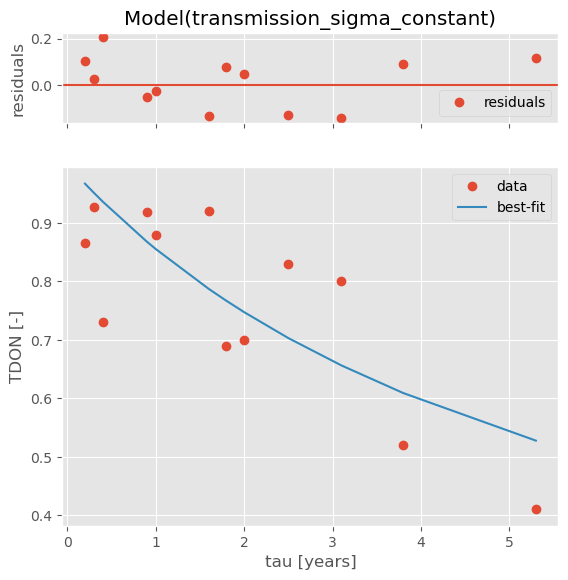

In [50]:
# Plot fit
fit1.plot(xlabel="tau [years]", ylabel="TDON [-]");

For DON, the best fit is with "option 1" with $\sigma = 0.17$ (+/- 0.03).

In the Steingruber data, the median LDIN/LTN ratio in the inflow is around 0.7 (IQR 0.47-0.76, which is high!), whilst in the outflow it is 0.4 (IQR 0.28-0.52). Because so much of the TN in this data is DIN, we would **expect the TN retention curve to be closer to the LDIN curve than the LDON curve**.

## 4. Suspended sediment (SS)

**To do**.

I would expect retention of SS to be highest out of all the parameters we're considering, since it settles quite quickly and, unlike TPP, doesn't undergo desorption back into the water column. This is just guessing for now, though! 

## 5. TOC

For TOC, authors like Dillon and Molot have estimated lake retention as a function of areal discharge, and there is widespread agreement that water residence time is a dominant factor controlling DOC degradation and removal. However, we haven't found any actual Vollenweider-style representations of retention to base parameter values on. The most useful thing we have found so far is the supplementary data to [this Evans et al. (2017) paper](https://www.nature.com/articles/ngeo3051) (note that a pdf of the paper is archived [here](https://nora.nerc.ac.uk/id/eprint/518436/1/N518436PP.pdf), but the supplementary data is downloaded from the publisher's website. As with N, we will therefore try deriving Vollenweider parameters using this data. N.B. that I have added the Langtjern budget to this data, to have one extra Norwegian data point.

### 5.1 Load Evans data

In [55]:
# Drop all lakes apart from those in Norway, Sweden, Finland and Canada?
drop_lakes = True

# If dropping lakes, choose which countries you want to keep. Choose from:
# 'Canada', 'Czech Republic', 'Finland', 'Norway', 'Sweden', 'UK',
# 'USA', 'USA/Canada', 'Malawi', 'Switzerland', 'Japan', 'Estonia',
# 'France'

countries_to_keep = ['Norway', 'Finland', 'Sweden', 'Canada']

data_fpath = r"../../data/Evans_DOC-retention_cleaned.xlsx"
df_raw = pd.read_excel(data_fpath, sheet_name='Data', index_col=0)

if drop_lakes:
    df = df_raw.query("Country in @countries_to_keep")
    print("Original n: %s, new n: %s, number dropped: %s" %(len(df_raw), len(df), len(df_raw)-len(df)))
else:
    df = df_raw

df_raw.head()

Original n: 83, new n: 48, number dropped: 35


/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Latitude,Longitude,Country,Type,Nutrient Status,Catchment_area_ha,Waterbody area_ha,Volume_m3,Discharge_m_per_yr,WRT_yr,DOCin,DOCout,DOCout/DOCin,R_DOC,T½,References,Notes,Type.1
Name,,,,,,,,,,,,,,,,,,
Langtjern,NaN,NaN,Norway,Lake,Oligotrophic,NaN,NaN,NaN,NaN,0.183333,7.300000,6.700000,0.917808,0.082192,NaN,deWit2018,LJB added,DOC sink
Blue Chalk,45° 12ʹ N,78° 56ʹ W,Canada,Lake,Oligotrophic,105.9,52.35,4450000.0,0.496209,5.666667,2.163469,0.886559,0.409786,0.590214,4.402807,S1,A,DOC sink
Chub,45° 12ʹ N,78° 58ʹ W,Canada,Lake,Oligotrophic,271.8,34.41,3062000.0,0.475341,2.104019,3.978035,2.337376,0.587571,0.412429,2.742587,S1,A,DOC sink
Crosson,45° 05ʹ N,79° 02ʹ W,Canada,Lake,Oligotrophic,521.8,56.74,5220000.0,0.549217,1.642857,3.893556,2.432247,0.624685,0.375315,2.420241,S1,A,DOC sink
Dickie,45° 08ʹ N,79° 05ʹ W,Canada,Lake,Oligotrophic,406.4,93.60,4680000.0,0.497952,1.879699,5.840640,2.658240,0.455128,0.544872,1.655167,S1,A,DOC sink


In [56]:
df.describe()

,Catchment_area_ha,Waterbody area_ha,Volume_m3,Discharge_m_per_yr,WRT_yr,DOCin,DOCout,DOCout/DOCin,R_DOC
count,4.700000e+01,47.000000,4.700000e+01,47.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,4.301669e+05,6505.314468,9.850925e+08,0.536152,2.758902,5.174086,4.224356,0.735693,0.264307
std,2.019845e+06,23213.447211,3.528975e+09,0.673296,4.078211,10.542456,11.986574,0.356785,0.356785
min,7.700000e+00,1.130000,1.100000e+04,0.037764,0.005292,0.288849,0.234139,0.272730,-0.904497
25%,8.875000e+01,8.750000,2.321000e+05,0.143007,0.500000,2.240527,1.176938,0.541836,0.128385
50%,2.114000e+02,34.410000,2.100000e+06,0.238636,1.521429,2.631165,1.809127,0.627236,0.372764
75%,6.790000e+03,83.800000,8.803000e+06,0.638418,2.617889,4.790542,2.658680,0.871615,0.458164
max,1.355000e+07,109600.000000,1.810000e+10,3.084536,19.300000,73.894407,83.957135,1.904497,0.727270


### 5.2 Fit TOC

Text(0.5, 0, 'tau [years]')

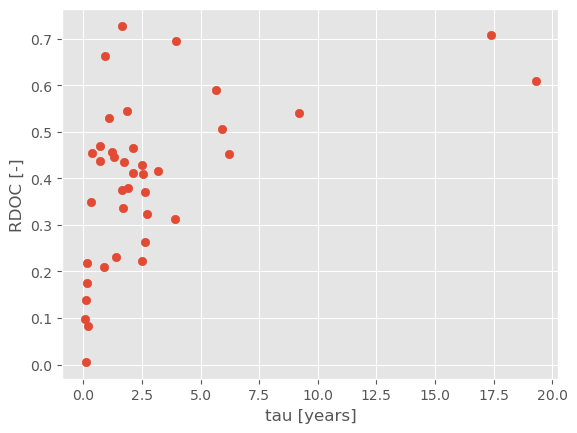

In [60]:
# Get data for DON
data_df = df[["R_DOC", "WRT_yr"]].dropna(how="any")

# Drop negative retention values
data_df = data_df.query("R_DOC > 0")

data_df["TDOC"] = 1 - data_df["R_DOC"]

# Sort for plotting
data_df.sort_values("WRT_yr", inplace=True)

# Plot
plt.scatter(data_df["WRT_yr"], data_df["R_DOC"], marker="o")
plt.ylabel("RDOC [-]")
plt.xlabel("tau [years]")
# plt.xscale("log");

In [64]:
# Try fitting the "option 1" model
model = Model(transmission_sigma_constant, independent_vars=["tau"])
fit1 = model.fit(data_df["TDOC"], tau=data_df["WRT_yr"])
print(fit1.fit_report())
r2 = 1 - fit1.residual.var() / np.var(data_df["TDOC"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 39
    # variables        = 1
    chi-square         = 1.29333675
    reduced chi-square = 0.03403518
    Akaike info crit   = -130.847109
    Bayesian info crit = -129.183548
[[Variables]]
    sigma:  0.34575578 +/- 0.05153373 (14.90%) (init = 1)
R2: -0.09


In [65]:
# Try fitting the "option 2" model
model = Model(transmission_sigma_as_func_of_tau, independent_vars=["tau"])
fit2 = model.fit(data_df["TDOC"], tau=data_df["WRT_yr"])
print(fit2.fit_report())
print(fit2.ci_report())
r2 = 1 - fit2.residual.var() / np.var(data_df["TDOC"])
print(f"R2: {r2:.2f}")

[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 39
    # variables        = 2
    chi-square         = 0.63898057
    reduced chi-square = 0.01726975
    Akaike info crit   = -156.346273
    Bayesian info crit = -153.019149
[[Variables]]
    k:  0.57191662 +/- 0.05932688 (10.37%) (init = 1)
    m: -0.62883408 +/- 0.07952588 (12.65%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m) = -0.466
      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k:  -0.17258  -0.11406  -0.05738   0.57192  +0.06078  +0.12830  +0.20718
 m:  -0.22333  -0.14726  -0.07407  -0.62883  +0.07910  +0.16848  +0.27598
R2: 0.45


(<Figure size 640x640 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

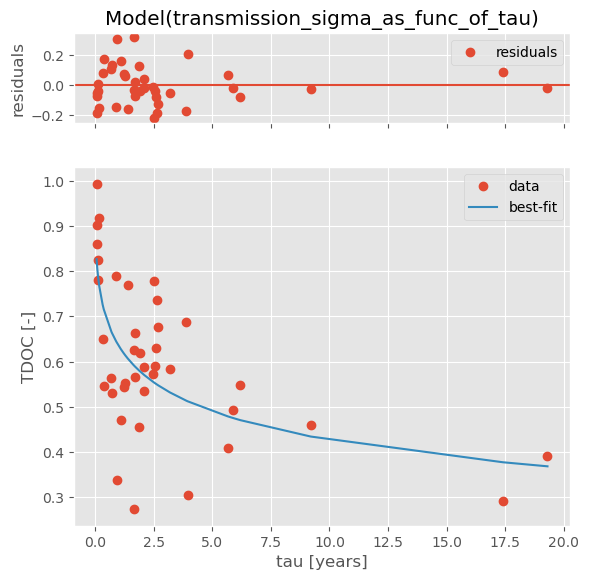

In [67]:
# Plot fit
fit2.plot(xlabel="tau [years]", ylabel="TDOC [-]")

The "option 2" model fits best, but there is lots of scatter. Fitted coefficients are  $\k = 0.57$ and $\m = -0.63$.

## 6. Summary

 * For transmission of **TOTP**, we have **solid evidence** for using
 
$$T_{TOTP} = \frac{1}{1 + \tau ^{0.5}}$$

 * For transmission of **TDP**, we have **weak evidence** for using the equation below (but this can hopefully be improved)
 
$$T_{TDP} = 0.4 + \frac{0.6}{1 + \tau ^{0.5}}$$

 * **TPP** will most likely be estimated as the difference between TOTP and TDP, unless we find an alternative method that is better than the approach currently proposed for TDP. For example, could we estimate $R_{TPP}$ as some fraction of $R_{SS}$?
 
 * For transmission of **TOTN**, we have **moderate evidence** for using the equation below. Note, however, that this will give much higher TOTN retention than the old version of the model, which raises some interesting questions 
 
$$T_{TOTN} = \frac{1}{1 + 0.75 \tau ^{0.4}}$$

 * For transmission of **DIN**, we have **solid evidence** for using
 
$$T_{DIN} = \frac{1}{1 + \tau}$$

 * **TON** will most likely be estimated as the difference between TOTN and DIN. However, fitting DON directly gives **weak evidence** (as based on far fewer data points than TN) for using the equation below.
 
$$T_{DON} = \frac{1}{1 + 0.17 \tau}$$

    In the Steingruber data, DIN makes up on average 70% of TN, so we would expect the TN curve to be something like
    $0.7 RDIN + 0.3 RDON$ I think??
 
 * **SS** needs further investigation, but I assume retention will be higher than for any of the other parameters considered. SS might also be appropriate for a "pure" Vollenweider approach ("option 1") as the assumption of a first order settling rate is perhaps more valid?
 
 * **TOC**: The "option 2" model fits best, but there is lots of scatter. Fitted coefficients are  $\k = 0.57$ and $\m = -0.63$. Could be worth trying things like subsetting the Evans data into different nutrient status, and seeing if that removes some of the scatter. We know that allocthonous DOM (which is more prevalent in mesotrophic and eutrophic lakes) has higher degradability than autocthonous DOM (main DOM type in oligotrophic lakes).
 
The curves below illustrate what we have so far).

Text(0.5, 1.0, 'Best fit estimates for curves based on literature (P) or data (rest)')

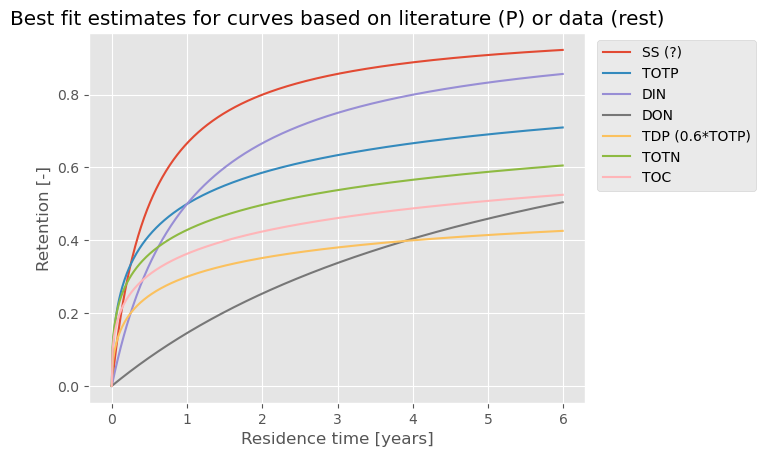

In [71]:
tau = np.arange(0, 6, 0.01)

# SS
ret = 1 - transmission_sigma_constant(tau, sigma=2)
plt.plot(tau, ret, ls="-", label=f"SS (?)")

# TOTP
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=1, m=-0.5)
plt.plot(tau, ret, ls="-", label=f"TOTP")

# DIN
ret = 1 - transmission_sigma_constant(tau, sigma=1)
plt.plot(tau, ret, ls="-", label=f"DIN")

# DON
ret = 1 - transmission_sigma_constant(tau, sigma=0.17)
plt.plot(tau, ret, ls="-", label=f"DON")

# TDP
ret = 0.6 * (1 - transmission_sigma_as_func_of_tau(tau, k=1, m=-0.5))
plt.plot(tau, ret, ls="-", label=f"TDP (0.6*TOTP)")

# # TDP2
# ret = 1 - transmission_sigma_as_func_of_tau(tau, k=0.4, m=-0.5)
# plt.plot(tau, ret, ls='-', label=f"TDP2 (k=0.4)")

# TOTN
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=0.75, m=-0.6)
plt.plot(tau, ret, ls="-", label=f"TOTN")

# TOC
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=0.57, m=-0.63)
plt.plot(tau, ret, ls="-", label=f"TOC")

plt.xlabel("Residence time [years]")
plt.ylabel("Retention [-]")
plt.legend(bbox_to_anchor=(1.01, 1))
# plt.savefig("relative_retention_ideas.png", dpi=150, bbox_inches="tight")

plt.title("Best fit estimates for curves based on literature (P) or data (rest)")

### Questions:

* Does the general ordering look ok? Related:
* Where should DON be relative to TOC?
* Should DIN be higher than TP, given the importance of sediment settling for P?
* How to stop the curves crossing at lower residence times?